In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

#import dask.dataframe as dd

from datetime import datetime

In [2]:
import keras 

from keras.preprocessing import sequence
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, LeakyReLU
from keras.layers import Embedding
from keras.layers import Concatenate, Flatten, Reshape, Lambda
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from keras.utils import plot_model
from keras import backend as K

from keras.datasets import imdb

Using TensorFlow backend.


In [3]:
#K.tensorflow_backend._get_available_gpus()

Helpful links:
1. Inverse of np.log1p: https://stackoverflow.com/questions/50049891/what-is-the-inverse-of-numpys-log1p
2. Building parallel keras model: https://stackoverflow.com/questions/43151775/how-to-have-parallel-convolutional-layers-in-keras
3. How to make parallel keras models: https://datascience.stackexchange.com/questions/39407/how-to-make-two-parallel-convolutional-neural-networks-in-keras
4. 2 parallel keras layers: https://stackoverflow.com/questions/51546075/two-parallel-conv2d-layers-keras
5. Setting up Conv1D and LSTM: https://stackoverflow.com/questions/51344610/how-to-setup-1d-convolution-and-lstm-in-keras
6. Take average of LSTM hidden states using Lambda: https://stackoverflow.com/questions/51479940/average-channels-of-convolutional-layer-keras
7. Preparing categorical variable for neural networks: https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
8. Tutorial for using keras for time series (no generators used): https://medium.com/@jdwittenauer/deep-learning-with-keras-structured-time-series-37a66c6aeb28


In [4]:
train = pd.read_csv("gs://123test_bucket/train.csv")

#### Scaling Meter Reading:
1. nplog1p
2. Group min-max scale

In [5]:
reading = train['meter_reading']
train['meter_reading'] = np.log1p(train['meter_reading'])

#scaler1 = MinMaxScaler()
#train['meter_reading'] = scaler1.fit_transform(X=np.reshape(train['meter_reading'].values, (-1, 1))).reshape(len(train),)

In [6]:
train['key'] = train['building_id'].astype(str) + train['meter'].astype(str)


In [7]:
sc_dict = dict()

def minmaxscaler(x, name, l):
    #print(name)
    key = name
    sc_dict[key]=MinMaxScaler()
    return sc_dict[key].fit_transform(X=np.reshape(x.values, (-1, 1))).reshape(l,)

In [8]:
train['meter_reading'] = train.groupby('key')['meter_reading'].transform(lambda x: minmaxscaler(x, x.name, len(x)))

In [9]:
len(sc_dict.keys())

2380

In [10]:
# for key in train['key'].unique():
#     print(key)
#     l = len(train.loc[train.key == key])
#     scaler1 = MinMaxScaler()
#     train.loc[train.key == key, 'meter_reading'] = scaler1.fit_transform(X=np.reshape(train.loc[train.key == key, 'meter_reading'].values, (-1, 1))).reshape(l,)
#     sc_dict[key] = scaler1

In [11]:
train['meter_reading'].mean()

0.6081818134202291

In [13]:
train = train.drop('key', axis=1)

In [14]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


#### Reading Test Data

In [15]:
test = pd.read_csv("gs://123test_bucket/test.csv")

In [16]:
train.timestamp = pd.to_datetime(train.timestamp)
test.timestamp = pd.to_datetime(test.timestamp)

In [17]:
len(train), len(test)

(20216100, 41697600)

#### Reading Weather and Meta Data

In [18]:
weather_train = pd.read_csv("gs://123test_bucket/weather_train.csv")
weather_test = pd.read_csv("gs://123test_bucket/weather_test.csv")
meta = pd.read_csv("gs://123test_bucket/building_metadata.csv")

In [19]:
weather_train.timestamp = pd.to_datetime(weather_train.timestamp)
weather_test.timestamp = pd.to_datetime(weather_test.timestamp)

In [20]:
train = pd.merge(pd.merge(train, meta, on='building_id', how='left'),
                 weather_train,
                 on=['site_id', 'timestamp'],
                 how='inner')
test = pd.merge(pd.merge(test, meta, on='building_id', how='left'),
                 weather_test,
                 on=['site_id', 'timestamp'],
                 how='left')

In [21]:
train['month'] = train.timestamp.dt.month
train['dayofweek'] = train.timestamp.dt.dayofweek
train['hour'] = train.timestamp.dt.hour

test['month'] = test.timestamp.dt.month
test['dayofweek'] = test.timestamp.dt.dayofweek
test['hour'] = test.timestamp.dt.hour

#### Adding Weekday/Weekend Flag

In [22]:
train['weekday'] = 0
test['weekday'] = 0
weekday_map = {0:0,
               1:0,
               2:0,
               3:0,
               4:0,
               5:1,
               6:1}
train['weekday'] = train['dayofweek'].map(weekday_map)
test['weekday'] = test['dayofweek'].map(weekday_map)

In [23]:
test.loc[40525*1024: (40525*1024)+1024]

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,dayofweek,hour,weekday
41497600,41497600,1337,1,2018-12-31 20:00:00,15,Office,14744,1910.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
41497601,41497601,1337,2,2018-12-31 20:00:00,15,Office,14744,1910.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
41497602,41497602,1338,0,2018-12-31 20:00:00,15,Education,31415,1912.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
41497603,41497603,1338,2,2018-12-31 20:00:00,15,Education,31415,1912.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
41497604,41497604,1339,0,2018-12-31 20:00:00,15,Education,140488,1961.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41498620,41498620,144,0,2017-01-18 09:00:00,1,Office,57673,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9,0
41498621,41498621,144,3,2017-01-18 09:00:00,1,Office,57673,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9,0
41498622,41498622,145,0,2017-01-18 09:00:00,1,Office,14219,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9,0
41498623,41498623,145,3,2017-01-18 09:00:00,1,Office,14219,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9,0


#### Scaling Data

In [24]:
train = train.fillna(0)
test = test.fillna(0)

In [25]:
scaler2 = MinMaxScaler()
num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'square_feet', 'floor_count']
scaler2.fit(train[num_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [26]:
train[num_cols] = scaler2.transform(train[num_cols])
test[num_cols] = scaler2.transform(test[num_cols])

#### Joining Weather, Metadata with load data

In [27]:
len(train), len(test)

(20125605, 41697600)

In [28]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month', 'dayofweek', 'hour', 'weekday'],
      dtype='object')

In [29]:
train.head(2)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,dayofweek,hour,weekday
0,0,0,2016-01-01,0.0,0,Education,0.008173,2008.0,0.0,0.708279,0.666667,0.900164,0.002907,0.975323,0.0,0.0,1,4,0,0
1,1,0,2016-01-01,0.0,0,Education,0.002786,2004.0,0.0,0.708279,0.666667,0.900164,0.002907,0.975323,0.0,0.0,1,4,0,0


#### Encoding Categorical Variables

In [30]:
enc = OrdinalEncoder()
cat_cols = ['site_id', 'hour', 'dayofweek', 'month', 'primary_use', 'year_built']
other_cols = ['building_id', 'meter']
enc.fit(train[cat_cols])


OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [31]:
train[cat_cols] = enc.transform(train[cat_cols])
test[cat_cols] = enc.transform(test[cat_cols])

#### Random ID selection

Using 30% of the data as validation data. If more data is needed, we should consider adding data by randomly selecting buildings.

In [32]:
ids = train['building_id'].unique()

In [33]:
# keeping 80% of the ids
len_sub = round(len(ids)*0.80)
ids_sub = np.random.choice(ids, len_sub, replace = False)

In [34]:
# 0.3 represents the percentage of data that is kept for validation
len_val = round(len(ids_sub)*0.3)

In [35]:
ids_val = np.random.choice(ids_sub, len_val, replace = False)

In [36]:
ids_train = np.setdiff1d(ids_sub,ids_val)

In [37]:
assert len(ids_val)+len(ids_train)==len(ids_sub)

#### Applying TimeseriesGenerator to the ASHRAE training data

Once difference between the example above, and our situation is that we have multiple timeseries, for each building and each meter in the building. So, we will be required to modify the code a little bit.

Below, we check how many meters exist in the dataset.

In [38]:
len(train[['building_id', 'meter']].drop_duplicates()), len(test[['building_id', 'meter']].drop_duplicates())

(2380, 2380)

The code below has been taken from this stackoverflow answer with some modifications:
https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id/55118459#55118459

The modification is basically that once we subset the data for building ID, it is then subset for meter type also.

Further reading about modifying keras generator classes can be found below:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

#### Defining Generators

In [39]:
num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'square_feet', 'floor_count'] 

cat_names = cat_cols + other_cols + ['weekday']

#new_cat_names = list(enc.get_feature_names(cat_names))

#col_names = num_cols + new_cat_names

In [40]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, dt, num_cols, cat_names, batch_size = 10):
        self.batch_size = batch_size
        self.len = len(dt)//batch_size
        self.dt = dt[num_cols + cat_names + ['meter_reading']]
        self.num_cols = num_cols
        self.cat_names = cat_names

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        index_start = index*self.batch_size
        index_end = index_start+self.batch_size
        adf = self.dt[index_start:index_end]
        return [adf[x] for x in cat_names]+[adf[num_cols]], adf['meter_reading']

In [97]:
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, dt, num_cols, cat_names, batch_size = 10):
        self.batch_size = batch_size
        self.len = round(len(dt)/batch_size)
        self.dt = dt[num_cols + cat_names]
        self.num_cols = num_cols
        self.cat_names = cat_names

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        index_start = index*self.batch_size
        index_end = index_start+self.batch_size
        adf = self.dt[index_start:index_end]
        return [adf[x] for x in cat_names]+[adf[num_cols]]

#### Training and Validation Generators

In [42]:
# Test
batch_size = 60*1024#1024+512
train_gen = DataGenerator(train[train['building_id'].isin(ids_train)], 
                          num_cols=num_cols, 
                          cat_names=cat_names,
                          batch_size=batch_size)
val_gen = DataGenerator(train[train['building_id'].isin(ids_val)],
                        num_cols=num_cols, 
                        cat_names=cat_names,
                        batch_size=batch_size)   


In [43]:
check1 = train_gen[0]
check2 = val_gen[0]

In [44]:
len(check1[0]), len(check2[0]), len(cat_names)+1

(10, 10, 10)

#### Loss Function - Root Mean Square

In [45]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#### Embeddings NN

1. https://towardsdatascience.com/decoded-entity-embeddings-of-categorical-variables-in-neural-networks-1d2468311635
2. https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9
3. https://github.com/mayanksatnalika/ipython/blob/master/embeddings%20project/cycle_sharing/entity_embeddings_regression.ipynb

In [46]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month', 'dayofweek', 'hour', 'weekday'],
      dtype='object')

In [47]:
len(train.columns)

20

In [48]:
len(cat_names), len(num_cols)

(9, 9)

In [49]:
models = []
inputs = []
act = 'relu'
n_num_cols = len(num_cols)


for categorical_var in cat_names:
    model = Sequential()
    model.reset_states()
    no_of_unique_cat  = train[categorical_var].nunique()
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
    embedding_size = int(embedding_size)
    input1 = Input(shape=(1,))
    model = Embedding(no_of_unique_cat+1,embedding_size)(input1)
    model = Reshape(target_shape=(embedding_size,))(model)
    models.append(model)
    inputs.append(input1)
    
input1 = Input(shape=(n_num_cols,))
model_rest = Dense(65, activation=act)(input1)
models.append(model_rest)
inputs.append(input1)

m1 = keras.layers.concatenate(models, axis = 1)
m1 = Dense(50, activation=act)(m1)
m1 = Dropout(0.5)(m1)
m1 = Dense(5, activation=act)(m1)
m1 = LeakyReLU(alpha=0.1)(m1)
m1 = Dropout(0.2)(m1)
m1 = Dense(1, activation='sigmoid')(m1)

model3 = Model(inputs = inputs, outputs = m1)

opt = keras.optimizers.RMSprop(clipnorm=1.)

model3.compile(loss=root_mean_squared_error, optimizer=opt, metrics=['mse', 'mae', 'mape'])

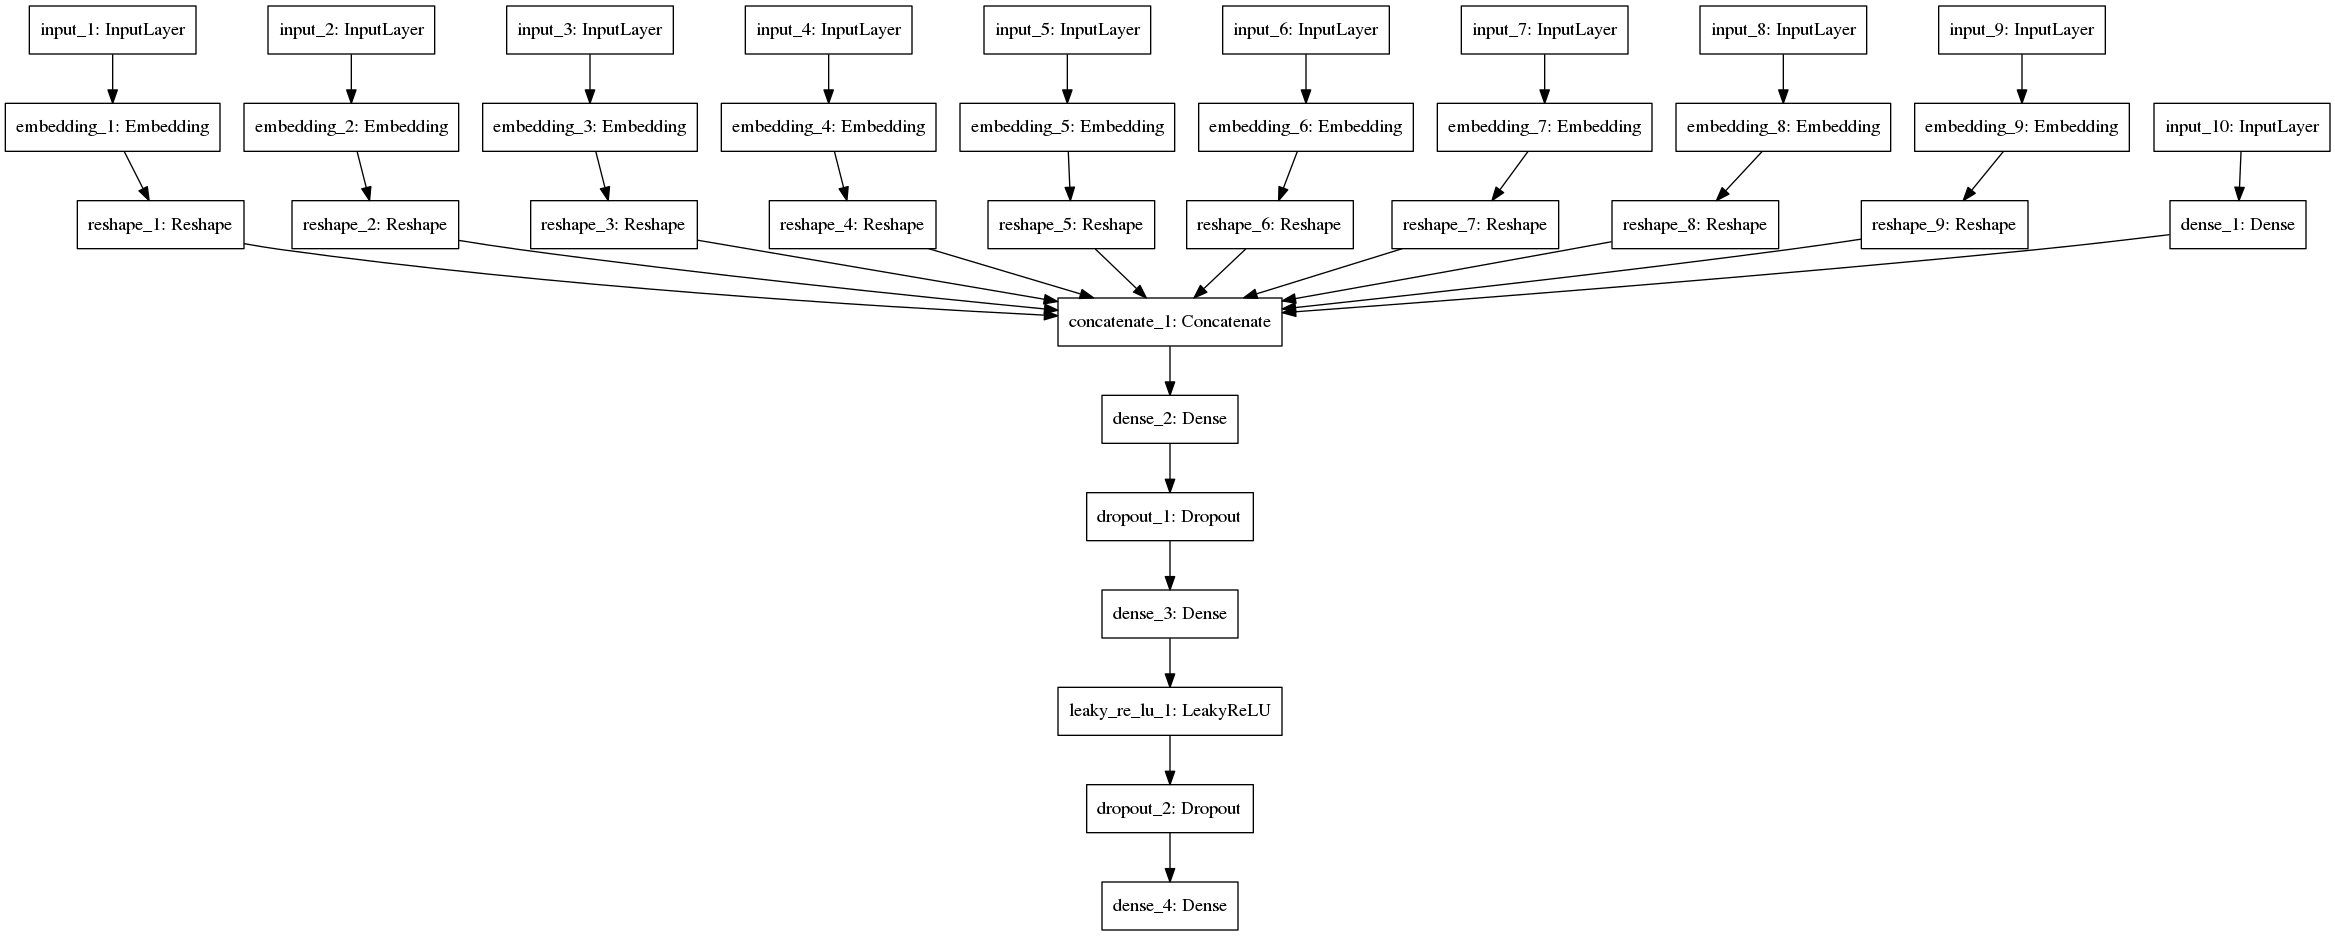

In [50]:
plot_model(model3)

In [51]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

In [52]:
epochs = 20#TODO: change it back to 5
workers = 10
model3.fit_generator(generator=train_gen,
                    validation_data=val_gen, epochs=epochs, 
                    use_multiprocessing=True, workers = workers)

/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
182/182 [==============================] - 14s 75ms/step - loss: 0.2594 - mse: 0.0678 - mae: 0.2038 - mape: 50330716.0000 - val_loss: 0.2829 - val_mse: 0.0777 - val_mae: 0.2235 - val_mape: 57506476.0000
Epoch 2/20
182/182 [==============================] - 13s 69ms/step - loss: 0.2410 - mse: 0.0584 - mae: 0.1835 - mape: 45545416.0000 - val_loss: 0.2802 - val_mse: 0.0778 - val_mae: 0.2295 - val_mape: 50026068.0000
Epoch 3/20
182/182 [==============================] - 12s 66ms/step - loss: 0.2319 - mse: 0.0541 - mae: 0.1744 - mape: 42018948.0000 - val_loss: 0.2838 - val_mse: 0.0778 - val_mae: 0.2260 - val_mape: 49245784.0000
Epoch 4/20
182/182 [==============================] - 12s 67ms/step - loss: 0.2226 - mse: 0.0499 - mae: 0.1649 - mape: 38966912.0000 - val_loss: 0.2821 - val_mse: 0.0791 - val_mae: 0.2318 - val_mape: 45081520.0000
Epoch 5/20
182/182 [==============================] - 12s 66ms/step - loss: 0.2150 - mse: 0.0466 - mae: 0.1572 - mape: 36289532.0000 - val_loss:

1. Dense(64) for model_rest, epoch 1: loss=0.0656, val_loss=0.1382, val_loss increased
2. Replacing the Dense(64) for model_rest with Dense(24), epoch 1: loss: 0.0648, val_loss: 0.1481, val_loss increased

In [56]:
val_test_gen = TestDataGenerator(train[train['building_id'].isin(ids_val[0:20])], 
                                 num_cols=num_cols, 
                                cat_names=cat_names,
                                batch_size=batch_size)
print(len(val_test_gen))

val_test_res = model3.predict_generator(generator=val_test_gen, workers=12, use_multiprocessing=True)

x = []
for i in range(len(val_test_gen)):
    x.append(val_gen[i][1].values)


5


In [59]:
dummy = train[train['building_id'].isin(ids_val[0:20])].copy()

In [64]:
dummy['y'] = val_test_res
dummy['key'] = dummy['building_id'].astype(str) + dummy['meter'].astype(str)


In [63]:
def inverseminmax(x, name, l):
    key = name
    return sc_dict[key].inverse_transform(np.reshape(x.values, (-1, 1))).reshape(l,)

In [67]:
val_test_y = np.expm1(dummy.groupby('key')['y'].transform(lambda x: inverseminmax(x, x.name, len(x))))

In [94]:
#print(len(val_test_y) == len(val_test_res_og))

In [119]:
print("Error: " +str({np.sqrt(np.mean(np.square(val_test_res_og - val_test_y)))}))

Error: {312372.7293354047}


#### Defining Function for Prediction - Method 1

In [98]:
test_gen = TestDataGenerator(test, num_cols=num_cols, 
                        cat_names=cat_names,
                        batch_size=batch_size)

In [99]:
len(test_gen)

679

In [100]:
cat_cols

['site_id', 'hour', 'dayofweek', 'month', 'primary_use', 'year_built']

In [101]:
#enc.categories_

In [102]:
#test.loc[40525*1024: (40525*1024)+1024]#.dt.month

In [104]:
result = model3.predict_generator(generator=test_gen, workers=12, use_multiprocessing=True, verbose=1)

679/679 [==============================] - 19s 28ms/step


In [105]:
result# = None

array([[0.00056562],
       [0.30450416],
       [0.08541593],
       ...,
       [0.5251958 ],
       [0.33792466],
       [0.3352927 ]], dtype=float32)

In [ ]:
result.shape

In [126]:
#pd.Series(np.expm1(scaler1.inverse_transform(result)).reshape(result.shape[0],))

In [127]:
#len(pd.read_csv("gs://123test_bucket/test.csv"))

In [128]:
41697600/batch_size

407.203125

In [112]:
(test.loc[0:10,'building_id'].astype(str) + test.loc[0:10,'meter'].astype(str)).values

array(['00', '10', '20', '30', '40', '50', '60', '70', '71', '80', '90'],
      dtype=object)

In [116]:
result_df = pd.DataFrame()
result_df['key'] = (test['building_id'].astype(str) + test['meter'].astype(str)).values

In [117]:
result_df['meter_reading']=result
result_df['row_id']=test['row_id']

In [118]:
result_df.head()

,key,meter_reading,row_id
0,00,0.000566,0
1,10,0.304504,1
2,20,0.085416,2
3,30,0.000918,3
4,40,0.000958,4


In [119]:
result_df['meter_reading'] = np.expm1(result_df.groupby('key')['meter_reading'].transform(lambda x: inverseminmax(x, x.name, len(x))))

In [120]:
result_df = result_df[['row_id', 'meter_reading']]

In [121]:
result_df.head(2)

,row_id,meter_reading
0,0,0.003460
1,1,4.411518


In [122]:
result_df.shape

(41697600, 2)

In [123]:
result_df.to_csv("gs://123test_bucket/result.csv", index=False)

In [61]:
check = pd.read_csv("result.csv")
check.shape

(41697600, 2)

In [68]:
result_df[result_df.meter_reading.isnull()]

,row_id,meter_reading


In [74]:
sample = pd.read_csv("gs://123test_bucket/sample_submission.csv")

In [76]:
sample['meter_reading'] = result_df['meter_reading']

In [77]:
sample = sample.fillna(0)

In [78]:
sample.to_csv("result_sample.csv", index=False)

In [79]:
# serialize model to JSON
model_json = model2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
